# IFC-Seq tutorial: predicting single-cell gene expression based on surface markers

In this tutorial we will see how to train a model in order to predict gene expression from 2 surface markers (CD34, FcgR) based on a Single-Cell Transcriptomics (SCT) mouse dataset from [Paul et al., Cell (2015)](https://www.sciencedirect.com/science/article/pii/S0092867415014932). Then we will apply the model in order to estimate gene expression for an Imaging Flow Cytometry (IFC) experiment that contains the same populations of interest.

**Table of Contents:**
- 1 Getting familiar with the dataset
  - 1.1 Celltype according to gate
  - 1.2 Plotting key marker genes
- 2 Predicting gene expression based on 2 surface markers
  - 2.1 Train a Random Forest (RF) to predict gene expression from CD34 and FcgR
  - 2.2 Use the trained Random Forest to predict gene expression for the SCT test set
- 3 Predicting gene expression for the IFC dataset
  - 3.1 Using the measured CD34 and FcgR values
  - 3.2 Label-free prediction of gene expression for the IFC experiment

Let's get started by loading the SCT dataset:

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import scanpy.api as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import h5py


#load the data
adata = sc.read('fpaul_raw_scRNA-Seq_minCells20.h5')

# 1 Getting familiar with the SCT dataset
## 1.1 Celltype according to gate
The cells in the datasets correspond to 3+1 different categories (celltypes), based on gating on the CD34 and FcgR surface markers. These categories are:
- **Megakaryocyte/Erythrocyte Progenitor (MEP)** cells: cells that fall in the MEP gate
- **Common Myeloid Progenitor (CMP)** cells: cells that fall in the CMP gate
- **Granulocyte/Macrophage Progenitor (GMP)** cells:  cells that fall in the GMP gate
- unknown cells: cells that do not fall in any of the above gates

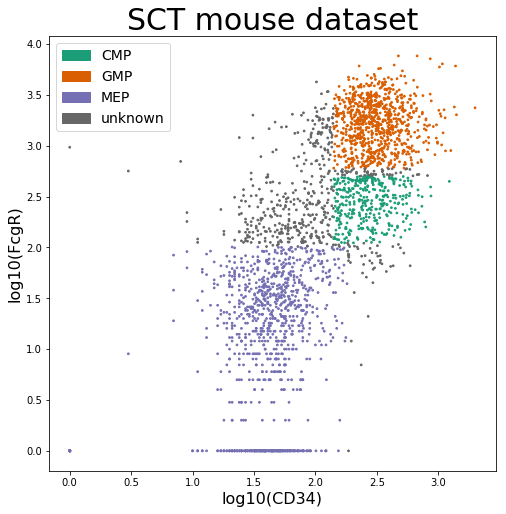

In [2]:
#let's plot the data, colored by celltype,

#easier to plot in 1 line, but not as nice:
#sc.pl.scatter(adata,'cd34_log','fcgr_log',color='celltype_gate',color_map='Dark2',title='Celltype')

cmap = plt.cm.Dark2

figsize=6
fig, axes = plt.subplots(1,1,figsize=(8,8))

#prepare the legend
CMP_patch = mpl.patches.Patch(color=cmap(0), label='CMP')
GMP_patch = mpl.patches.Patch(color=cmap(1), label='GMP')
MEP_patch = mpl.patches.Patch(color=cmap(2), label='MEP')
unknown_patch = mpl.patches.Patch(color=cmap(7), label='unknown')
handles = [CMP_patch, GMP_patch,MEP_patch,unknown_patch]

#plot the celltypes on top of CD34 and FcgR markers
ax = axes
cell_color=adata.obs['celltype_gate'].cat.codes.values.copy()
cell_color[adata.obs['celltype_gate']=='unknown']=7#to paint gray
ax.scatter(adata.obs['cd34_log'],adata.obs['fcgr_log'],
           c=cmap(cell_color),s=3)
ax.set_xlabel('log10(CD34)',{'fontsize':16})
ax.set_ylabel('log10(FcgR)',{'fontsize':16})
ax.set_title('SCT mouse dataset',{'fontsize':30})
ax.legend(handles=handles,prop={"size":14})
plt.show()

## 1.2 Plotting key marker genes

Now let's plot some key marker genes for each population, on top of the CD34 vs FcgR scatter plot. We will plot the following marker genes: Blvrb and Klf1 for MEP cells, Serpina3f for CMP cells, Napsa and Ly6c2 for GMP cells, while Coro1a is expressed in both CMP and GMP cells.

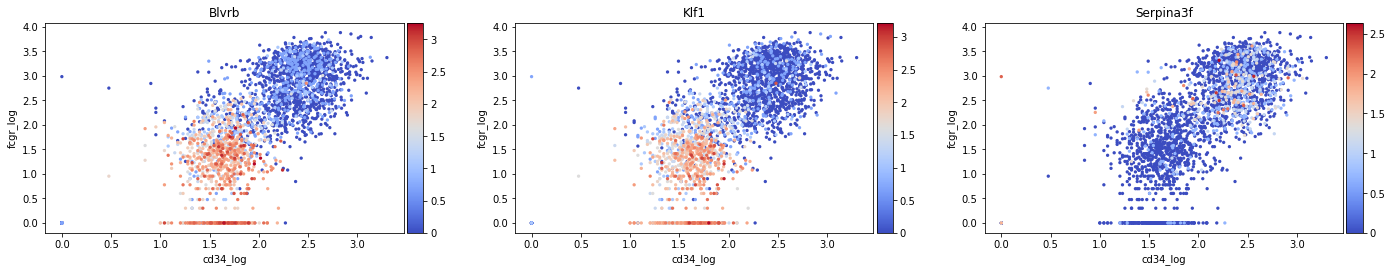

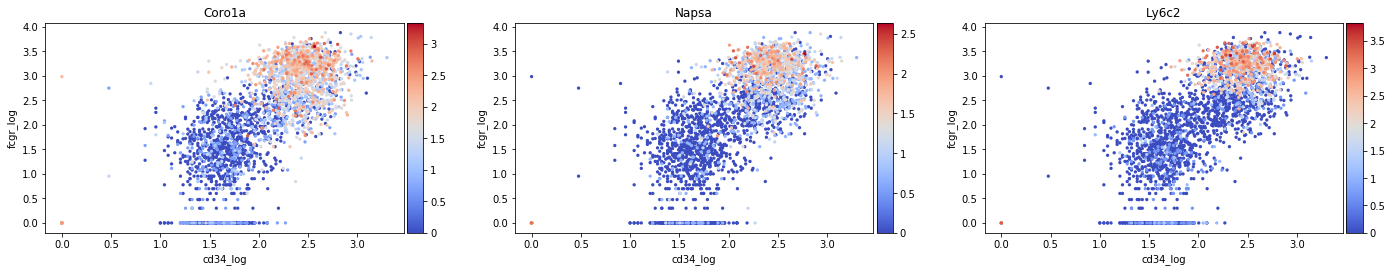

In [3]:
#genes_to_plot = ['Blvrb','Klf1','Serpina3f','Coro1a','Napsa','Ly6c2']
genes_to_plot = ['Blvrb',#MEP marker
                 'Klf1',#MEP marker
                 'Serpina3f']#CMP marker
sc.pl.scatter(adata,'cd34_log','fcgr_log',color=genes_to_plot,color_map='coolwarm')
genes_to_plot = ['Coro1a',#CMP and GMP marker
                 'Napsa',#GMP marker
                 'Ly6c2']#GMP marker
sc.pl.scatter(adata,'cd34_log','fcgr_log',color=genes_to_plot,color_map='coolwarm')

# 2 Predicting gene expression based on 2 surface markers
## 2.1 Train a Random Forest (RF) to predict gene expression from CD34 and FcgR

We will first train a random forest on the 70% training split of SCT dataset, in order to predict gene expression based only on the values of CD34 and FcgR. We will normalize the markers in the 0-1 range.

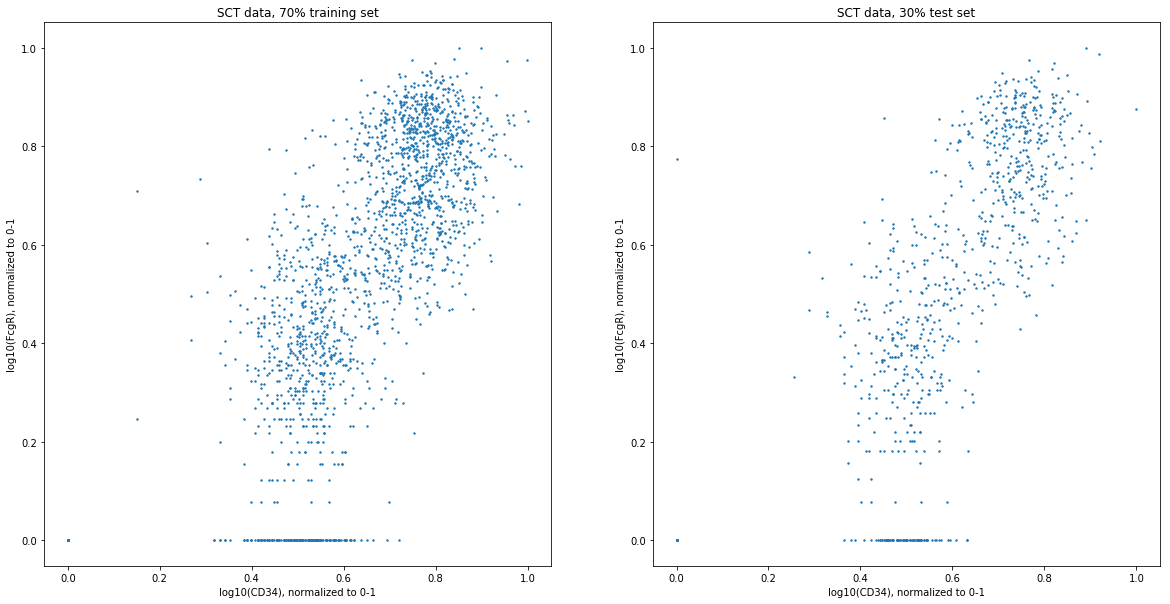

In [4]:
from sklearn.ensemble import RandomForestRegressor
from numpy import inf
import joblib #to save the trained RF model

marker1 = 'cd34_log'
marker2 = 'fcgr_log'

#indices of the train and test splits
ix_train=adata.obs['ix_train']#70% training split
ix_test=adata.obs['ix_test']#30% test split

adata_predict = adata.copy()#make a copy, just to be on the safe side
genes_kept = adata_predict.var_names.values#keep all genes

#gene matrix: output to predict
Y = np.array(adata_predict.X)

#surface markers to use as input
X = np.concatenate((np.expand_dims(adata_predict.obs[marker1].values,1),
                    np.expand_dims(adata_predict.obs[marker2].values,1)),axis=1)

#sanity check
assert np.array_equal(X[:,0],adata_predict.obs[marker1].values)
assert np.array_equal(X[:,1],adata_predict.obs[marker2].values)

def normalize_markers_01(X_raw):
    #normalized surface markers to use as input, exact same results as non-normalized
    #subtract min and divide by max to get it in [0,1] range
    for c in np.arange(X_raw.shape[1]):#iterate over columns
        X_raw[:,c][X_raw[:,c]==-inf]=0
        X_raw[:,c] = X_raw[:,c]-np.nanmin(X_raw[:,c])
        X_raw[:,c] = X_raw[:,c]/np.nanmax(X_raw[:,c])
    X_raw[np.isnan(X_raw)] = 0#pad nans with 0
    return(X_raw)

#pad -Inf to zero
X[X == -inf] = 0

#split into train and test sets
X_tr = X[ix_train,:]
X_ts = X[ix_test,:]
Y_tr = Y[ix_train,:]
Y_ts = Y[ix_test,:]

#no negative marker values in the scRNAseq data
assert np.isnan(X).sum() == 0

#normalize markers to 0-1 range
X_tr = normalize_markers_01(X_tr)
X_ts = normalize_markers_01(X_ts)

#plot the training and the test set, on top of normalized marker scatterplot
plt.figure(figsize=(2*10,10))
plt.subplot(1,2,1)
plt.scatter(X_tr[:,0],X_tr[:,1],s=2)
plt.xlabel('log10(CD34), normalized to 0-1')
plt.ylabel('log10(FcgR), normalized to 0-1')
plt.title('SCT data, 70% training set')
plt.subplot(1,2,2)
plt.scatter(X_ts[:,0],X_ts[:,1],s=2)
plt.xlabel('log10(CD34), normalized to 0-1')
plt.ylabel('log10(FcgR), normalized to 0-1')
plt.title('SCT data, 30% test set')
plt.show()

In [5]:
#Now train the random forest for regression on the train set

################################################################
# CAUTION: This can take a while. To avoid waiting a pre-trained
# model is provided. If you want to train the RF from scratch,
# set train_new_RF to to True.
################################################################

train_new_RF = False #use pre-trained Random Forest

if train_new_RF == True:
    n_estimators = 50
    criterion='mae'
    max_features = 'sqrt'
    n_jobs=-1#use all available cores

    print('training the RF')
    rf = RandomForestRegressor(n_estimators=n_estimators, criterion=criterion,
                               max_features=max_features, random_state=0, n_jobs=n_jobs)

    rf.fit(X_tr,Y_tr)

    #predict on new data
    Y_ts_hat = rf.predict(X_ts)

    #%% save pre-trained RF to disk
    joblib.dump(rf,'rf_fpaul_raw_scRNA-Seq_minCells20_01norm_50trees',compress=True)
    print(rf)
    print('RF trained and saved!')

## 2.2 Use the trained Random Forest to predict gene expression for the SCT test set

We will now load the RF we saved to disk. Then we will use to to predict gene expression based on CD34 and FcgR values for the 30% test split of the SCT dataset.

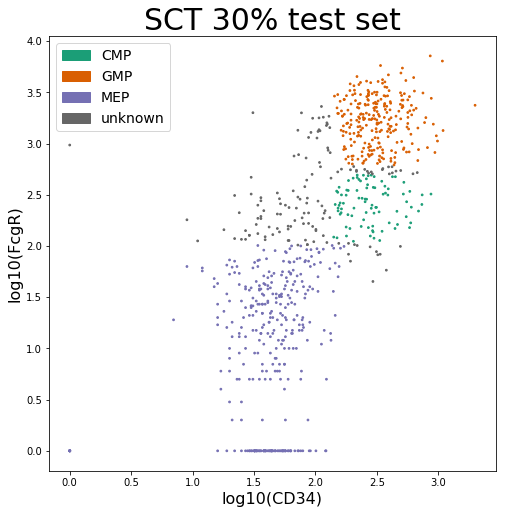

In [6]:
#load the saved RF
rf = joblib.load('rf_fpaul_raw_scRNA-Seq_minCells20_01norm_50trees.pkl')

#predict the gene matrix
genes_RF = rf.predict(X_ts)

y_gate_scRNAseq=adata.obs['celltype_gate']

#create adata based on the predicted gene matrix
y_gate = y_gate_scRNAseq.loc[ix_test.values]
adata_RF = sc.AnnData(X=genes_RF)
adata_RF.var_names = adata.var_names#fix the gene names
adata_RF.obs['celltype_gate'] = pd.Categorical(y_gate.values, categories=y_gate.cat.categories)
adata_RF.obs['cd34_log'] = adata.obs['cd34_log'].loc[ix_test].values#.values necessary or index gets messed up
adata_RF.obs['fcgr_log'] = adata.obs['fcgr_log'].loc[ix_test].values#.values necessary or index gets messed up

#sanity check, that the celltypes are OK in the new adata
fig, axes = plt.subplots(1,1,figsize=(8,8))
ax = axes
cell_color=adata_RF.obs['celltype_gate'].cat.codes.values.copy()
cell_color[adata_RF.obs['celltype_gate']=='unknown']=7#to paint gray
ax.scatter(adata_RF.obs['cd34_log'],adata_RF.obs['fcgr_log'],
           c=cmap(cell_color),s=3)
ax.set_xlabel('log10(CD34)',{'fontsize':16})
ax.set_ylabel('log10(FcgR)',{'fontsize':16})
ax.set_title('SCT 30% test set',{'fontsize':30})
ax.legend(handles=handles,prop={"size":14})
plt.show()

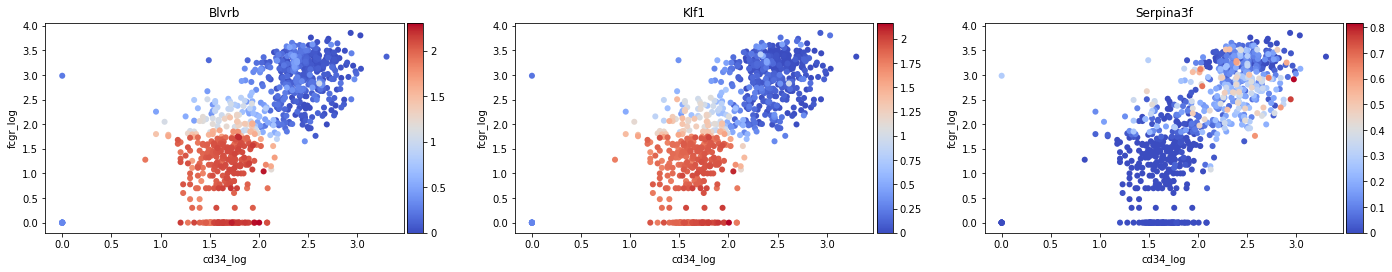

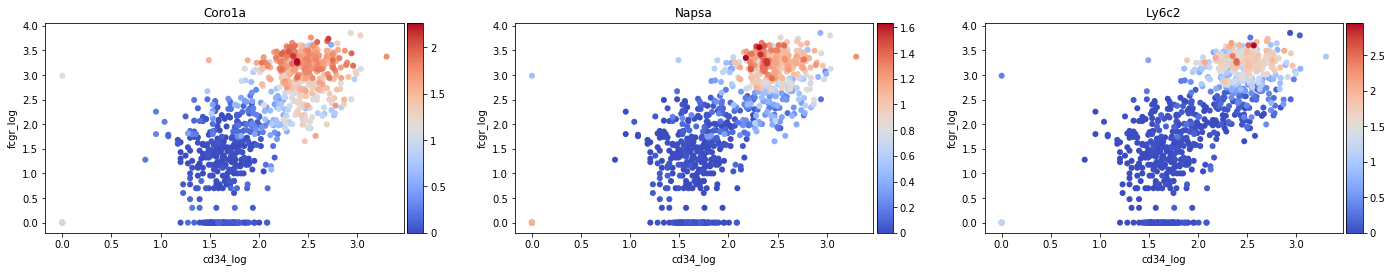

In [7]:
#Now let's plot the predicted expression for the same key markers as above
genes_to_plot = ['Blvrb',#MEP marker
                 'Klf1',#MEP marker
                 'Serpina3f']#CMP marker
sc.pl.scatter(adata_RF,'cd34_log','fcgr_log',color=genes_to_plot,color_map='coolwarm')
genes_to_plot = ['Coro1a',#CMP and GMP marker
                 'Napsa',#GMP marker
                 'Ly6c2']#GMP marker
sc.pl.scatter(adata_RF,'cd34_log','fcgr_log',color=genes_to_plot,color_map='coolwarm')

We can see that the predicted expression profiles of these marker genes are very close to the ground truth plots above. But how does the model perform quantitatively? We can check the correlation of ground-truh vs predicted expression for each gene, as follows:

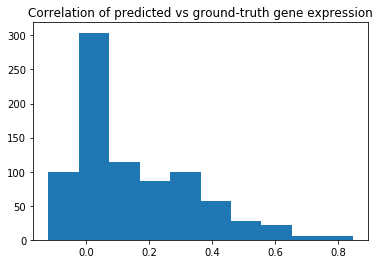

In [8]:
ngenes = Y_ts.shape[0]
gene_correlations = np.zeros(ngenes)
for gene in range(ngenes):
    gene_correlations[gene] = np.corrcoef(Y_ts[:,gene],genes_RF[:,gene])[0][1]
plt.hist(gene_correlations)
plt.title('Correlation of predicted vs ground-truth gene expression')
plt.show()

In [9]:
for threshold in np.arange(0.3,0.9,0.1):
    print('correlation threshold',threshold)
    print('genes above threshold', np.sum(gene_correlations>threshold))
    print('\n')

correlation threshold 0.3
genes above threshold 179


correlation threshold 0.4
genes above threshold 88


correlation threshold 0.5
genes above threshold 43


correlation threshold 0.6000000000000001
genes above threshold 18


correlation threshold 0.7000000000000002
genes above threshold 7


correlation threshold 0.8000000000000003
genes above threshold 3


correlation threshold 0.9000000000000001
genes above threshold 0




As we can see, a many genes are weakly predicted (low correlation to ground truth). Nonetheless, a subset of genes are strongly predicted just from these two surface markers (CD34, FcgR). We hypothesize that these are the marker genes relevant to the subpopulations (CMP, GMP, MEP) defined by these markers. That is why the key markers we plotted above look so convincing. Let's take a closer look:

best gene is Car2


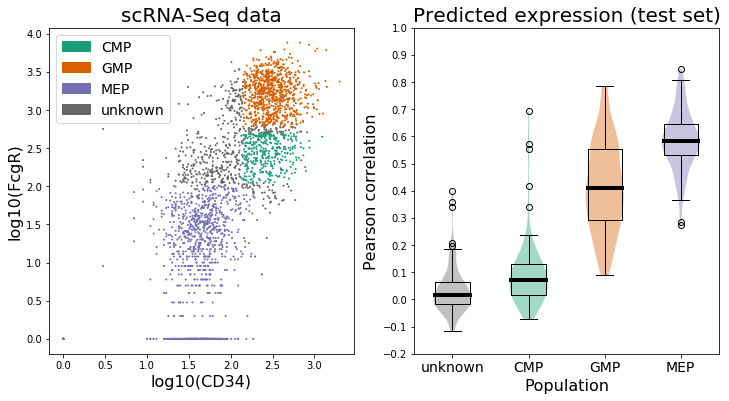

In [10]:
#marker genes for each population according to the test set
df_test = pd.read_csv('mouse_scRNA-Seq_2trueMarkers_top100Genes_test.csv')#includes gene markers per population

genes_kept = adata.var_names.values#keep all genes

Y_ts = adata.X[ix_test,:]#true gene values
Y_ts_hat = genes_RF

assert(Y_ts.shape==Y_ts_hat.shape)

ngenes_total=Y_ts.shape[1]#genes per celltype * 3 celltypes
gene_correlations = np.zeros(ngenes_total)

ix_CMP_markers_test=[]
ix_GMP_markers_test=[]
ix_MEP_markers_test=[]
ix_UNK_markers_test=[]#unknown

#calculate correlation per gene
for g in range(ngenes_total):
    #print('correlation for gene',g,'is',np.corrcoef(Y_ts[:,g],Y_ts_hat[:,g])[0][1])
    gene_correlations[g]=np.corrcoef(Y_ts[:,g],Y_ts_hat[:,g])[0][1]
    if genes_kept[g] in df_test['CMP'].values:
        ix_CMP_markers_test.append(g)
    if genes_kept[g] in df_test['GMP'].values:
        ix_GMP_markers_test.append(g)
    if genes_kept[g] in df_test['MEP'].values:
        ix_MEP_markers_test.append(g)
    if genes_kept[g] in df_test['unknown'].values:
        ix_UNK_markers_test.append(g)

assert(len(np.where(np.isnan(gene_correlations))[0])==0)

assert len(ix_CMP_markers_test)==len(df_test['CMP'])
assert len(ix_GMP_markers_test)==len(df_test['GMP'])
assert len(ix_MEP_markers_test)==len(df_test['MEP'])

print('best gene is',genes_kept[np.argmax(gene_correlations)])

cmap = plt.cm.Dark2  
#prepare the legend
CMP_patch = mpl.patches.Patch(color=cmap(0), label='CMP')
GMP_patch = mpl.patches.Patch(color=cmap(1), label='GMP')
MEP_patch = mpl.patches.Patch(color=cmap(2), label='MEP')
unknown_patch = mpl.patches.Patch(color=cmap(7), label='unknown')
handles = [CMP_patch, GMP_patch,MEP_patch,unknown_patch]

#now plot gates and correlation
populations = ['CMP','GMP','MEP']
figsize=6
fig, axes = plt.subplots(nrows=1, ncols=2, sharex = False, sharey = False,figsize=(figsize*2,figsize))
#plot the scRNAseq train data
ax = axes[0]
cell_color=adata.obs['celltype_gate'].cat.codes.values.copy()
cell_color[adata.obs['celltype_gate']=='unknown']=7#to paint gray
ax.scatter(adata.obs['cd34_log'],adata.obs['fcgr_log'],
           c=cmap(cell_color),s=1)
ax.set_xlabel('log10(CD34)',{'fontsize':16})
ax.set_ylabel('log10(FcgR)',{'fontsize':16})
ax.set_title('scRNA-Seq data',{'fontsize':20})
#add the gate for each population
for gate_pop in populations:
    x_low=adata.obs['cd34_log'][adata.obs['celltype_gate']==gate_pop].min()
    x_high=adata.obs['cd34_log'][adata.obs['celltype_gate']==gate_pop].max()
    y_low=adata.obs['fcgr_log'][adata.obs['celltype_gate']==gate_pop].min()
    y_high=adata.obs['fcgr_log'][adata.obs['celltype_gate']==gate_pop].max()
    #add_gate_square(ax,x_low,x_high,y_low,y_high)
ax.legend(handles=handles,prop={"size":14})
ax.legend(handles=handles,prop={"size":14})

#plot the correlations for true vs predicted genes on the test set
#plot correlations for all genes and for gene subsets/markers for the
#interesting populations (CMP, GMP and MEP)
cmap = plt.cm.Dark2
population_colors = [cmap(7),cmap(0),cmap(1),cmap(2)]#All cells, CMP, GMP, MEP

ρ_all = gene_correlations
ρ_CMP = gene_correlations[ix_CMP_markers_test]
ρ_GMP = gene_correlations[ix_GMP_markers_test]
ρ_MEP = gene_correlations[ix_MEP_markers_test]
ρ_UNK = gene_correlations[ix_UNK_markers_test]

#violin_values = [ρ_all,ρ_CMP,ρ_GMP,ρ_MEP]
#violin_labels = ['All','CMP','GMP','MEP']

violin_values = [ρ_UNK,ρ_CMP,ρ_GMP,ρ_MEP]
violin_labels = ['unknown','CMP','GMP','MEP']

ax=axes[1]
vplots = ax.violinplot(violin_values,showmedians=True, showextrema=False)
i=0
for patch in vplots['bodies']:
    patch.set_facecolor(population_colors[i])
    patch.set_alpha(0.4)
    i=i+1   
vplots['cmedians'].set_edgecolor('black')
vplots['cmedians'].set_linewidth(2)

bplots = ax.boxplot(violin_values,patch_artist=False, labels = violin_labels)
for patch in bplots['medians']:
    patch.set_color('black')
    patch.set_lw(4)
    
#ax.boxplot(c[0:50])
ax.set_xticks(np.arange(len(violin_labels))+1)
ax.set_xticklabels(violin_labels)
ax.set_ylim(-0.2,1)
ax.set_ylabel('Pearson correlation',{'fontsize':16})
ax.set_xlabel('Population',{'fontsize':16})
ax.set_yticks(np.arange(-0.2,1.1,0.1))
ax.set_xticklabels(ax.get_xticklabels(),{'fontsize':14})
ax.set_title('Predicted expression (test set)',{'fontsize':20})
plt.show()

As we can see above, our initial hypothesis is correct. Prediction quality (correlation) is better for marker genes for the populations of interest, especially for the GMP and MEP cells. The bulk of low correlated genes correspond to the "unknown" population that is not related to the two markers (CD34, FcgR) that were used to predict gene expression

# 3 Predicting gene expression for the IFC dataset
## 3.1 Using the measured CD34 and FcgR values

We will now use the Random Forest we trained with the SCT experiment, to predict gene expression for a new Imaging Flow Cytometry (IFC) dataset. The same markers (CD34, FcgR) have been measured for each cell of the IFC experiment. As such, we will proceed to normalize the markers to 0-1 and then use the saved RF to predict gene expression for each cell.

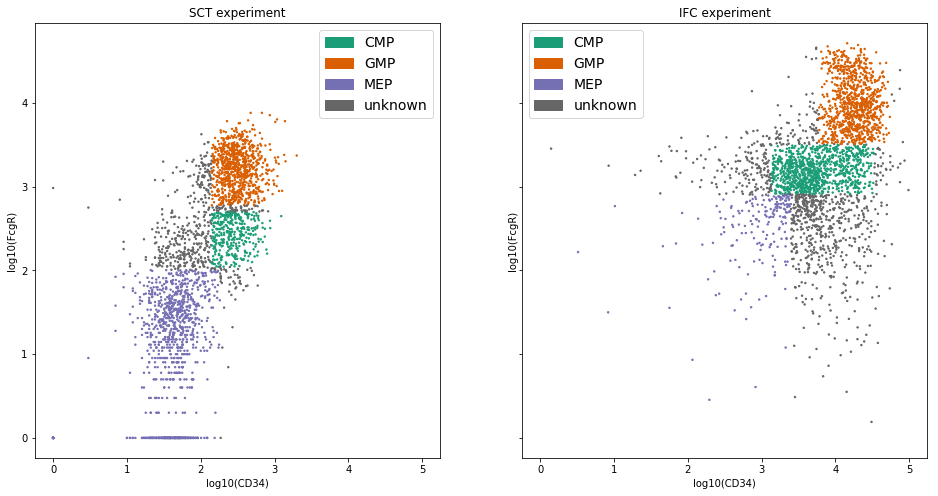

In [11]:
#load the IFC experiment
h5f = h5py.File('X_fpaul_exp1.h5','r')
X_img = h5f['X'][()]
y_img = h5f['y'][()]
cd34_img = h5f['intensity_CD34'][()]
fcgr_img = h5f['intensity_FcgR'][()]
obj_id_img = h5f['obj_id'][()].astype('int')
h5f.close()

#convert celltype label of each cell to categorical
y_img = np.array([x.decode('utf-8') for x in y_img])
y_img_cat = pd.Series(y_img,dtype='category')
y_gate_IFC = y_img_cat

#convert markers to log scale
cd34_img_log = np.log10(cd34_img+1)
fcgr_img_log = np.log10(fcgr_img+1)

#plot the SCT and the new IFC experiment side by side
fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(2*8,8))
ax=axes[0]
cell_colors_SCT=y_gate_scRNAseq.cat.codes.values.copy()
cell_colors_SCT[cell_colors_SCT==3]=7#convert "unknown" cells to gray
#Categories (3, object): [CD3+CD8+, CD3+CD8-, unknown]
ax.scatter(adata.obs['cd34_log'],adata.obs['fcgr_log'],c=cmap(cell_colors_SCT),s=2)
ax.set_title('SCT experiment')
ax.set_xlabel('log10(CD34)')
ax.set_ylabel('log10(FcgR)')
ax.legend(handles=handles,prop={"size":14})
ax=axes[1]
#Categories (3, object): [CD3+CD8+, CD3+CD8-, unknown]
cell_colors_IFC=y_gate_IFC.cat.codes.values.copy()
cell_colors_IFC[cell_colors_IFC==3]=7#convert "unknown" cells to gray
ax.scatter(cd34_img_log,fcgr_img_log,c=cmap(cell_colors_IFC),s=2)
ax.set_title('IFC experiment')
ax.set_xlabel('log10(CD34)')
ax.set_ylabel('log10(FcgR)')
ax.legend(handles=handles,prop={"size":14})
plt.show()

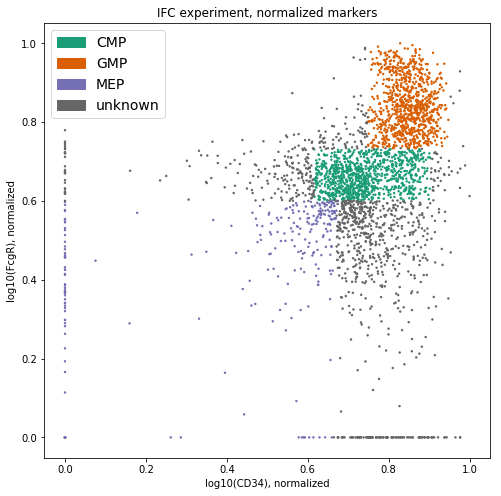

In [12]:
#now normalize the IFC data to 0-1
#concatenate
X_markers_img = np.concatenate((np.expand_dims(cd34_img_log,1),
                                np.expand_dims(fcgr_img_log,1)),axis=1)

#normalize and predict
X_markers_img_01norm = normalize_markers_01(X_markers_img)

#plot the normalized markers
plt.figure(figsize=(8,8))
plt.scatter(X_markers_img_01norm[:,0],X_markers_img_01norm[:,1],c=plt.cm.Dark2(cell_colors_IFC),s=2)
plt.title('IFC experiment, normalized markers')
plt.xlabel('log10(CD34), normalized')
plt.ylabel('log10(FcgR), normalized')
plt.legend(handles=handles,prop={"size":14})
plt.show()

In [13]:
#predict the gene matrix with a Random Forest
genes_IFC = rf.predict(X_markers_img_01norm)

#create adata based on the predicted gene matrix
y_gate = y_gate_IFC
adata_IFC = sc.AnnData(X=genes_IFC)
adata_IFC.var_names = adata.var_names#fix the gene names
adata_IFC.obs['celltype_gate'] = pd.Categorical(y_gate.values, categories=y_gate.cat.categories)
adata_IFC.obs['fcgr_log'] = fcgr_img_log
adata_IFC.obs['cd34_log'] = cd34_img_log

#save to disk
sc.write('./adata_mouse_IFC.h5',adata_IFC)

Now let's plot the same marker genes as before and see if the predictions make sense.

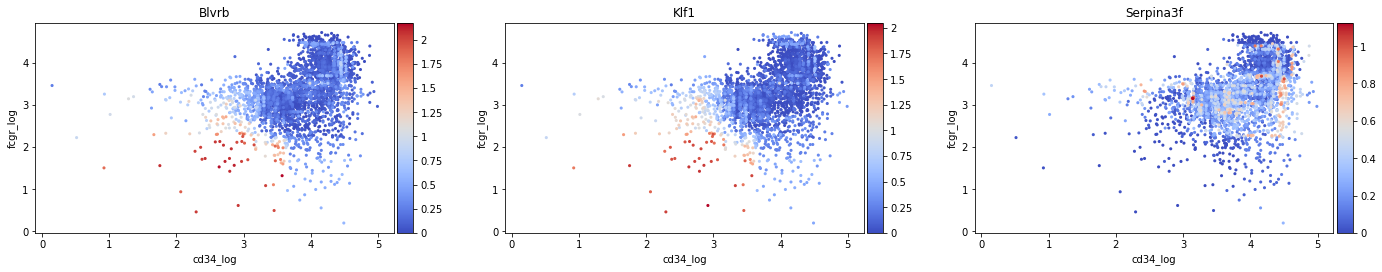

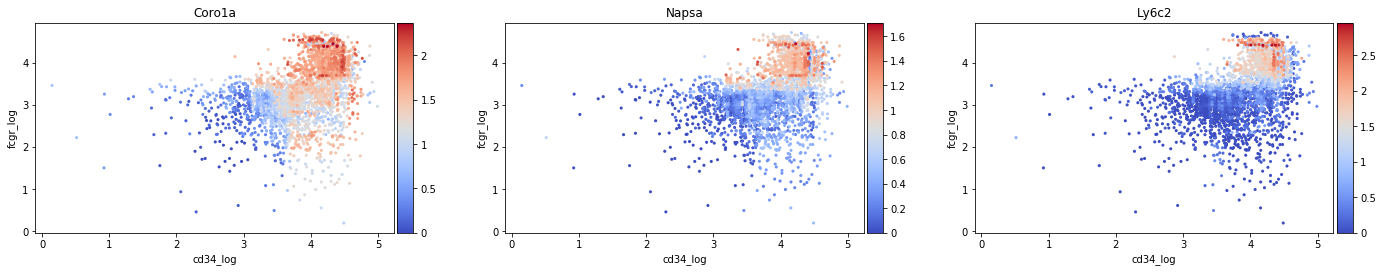

In [14]:
#Now let's plot the predicted expression for the same key markers as above
genes_to_plot = ['Blvrb',#MEP marker
                 'Klf1',#MEP marker
                 'Serpina3f']#CMP marker
sc.pl.scatter(adata_IFC,'cd34_log','fcgr_log',color=genes_to_plot,color_map='coolwarm')
genes_to_plot = ['Coro1a',#CMP and GMP marker
                 'Napsa',#GMP marker
                 'Ly6c2']#GMP marker
sc.pl.scatter(adata_IFC,'cd34_log','fcgr_log',color=genes_to_plot,color_map='coolwarm')

We can see that the marker genes have been predicted and localized successfully. MEP markers Blvrb and Klf1 are expressed in the MEP region, CMP marker Serpina3f is expressed in the CMP region, GMP markers Napsa and Ly6c2 are expressed in the GMP region. Finally, CMP and GMP marker Coro1a, is expressed in both the CMP and GMP regions.

## 3.2 Label-free prediction of gene expression for the IFC experiment

We saw that predicting gene expression from measured CD34 and FcgR values works for the IFC experiment. Next, we will proceed to predict gene expression in a label free manner. To be precise, we will use a Convolutional Neural Network (CNN) to predict both CD34 and FcgR from the Brightfield image of each cell. Each Brightfield image is 32x32 pixels in size. After predicting CD34 and FcgR for each cell, we will proceed to predict gene expression with a Random Forest, exactly like in the previous section. First, let's plot some of the Brightfield images to get a feeling of the dataset.

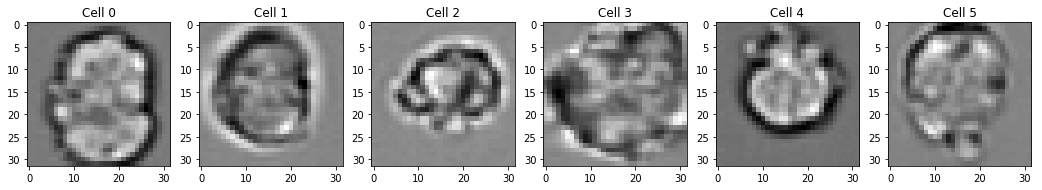

In [15]:
#subselect only the Brightfield (BF) channel from each image.
X_img_BF = X_img[:,:,:,0]#only BF channel
#need to reshape before feeding into the CNN
X_img_BF = X_img_BF.reshape(X_img_BF.shape+(1,))

#plot a few images from cells
plt.figure(figsize=(6*3,3))
for i in range(6):
    plt.subplot(1,6,i+1)
    plt.imshow(X_img_BF[i,:,:,0],cmap='gray')
    plt.title('Cell '+str(i))
plt.show()

Now we will load a CNN that has been trained on another independent dataset, in order to predict CD34 and FcgR from Brightfield images of cells. Predicting with a CNN is time consuming (especially on a CPU), so we will save the predicted CD34 and FcgR values to disk for easy access. 

In [16]:
#load the network to predict the intensities
#model = load_model('CNN.hdf5')
#(cd34_pred, fcgr_pred) = model.predict(X_img_BF)

#save to disk
#np.save('CNN_predicted_cd34',cd34_pred)
#np.save('CNN_predicted_fcgr',fcgr_pred)

Now we can simply load the predicted values for CD34 and FcgR directly from the disk.

In [17]:
cd34_pred = np.load('CNN_predicted_cd34.npy')
fcgr_pred = np.load('CNN_predicted_fcgr.npy')

#let's see the correlation between the predicted and ground truth values
print('Correlation for CD34 predicted vs Ground-truth',np.round(np.corrcoef(cd34_pred.flatten(),cd34_img)[0][1],2))
print('Correlation for FcgR predicted vs Ground-truth',np.round(np.corrcoef(fcgr_pred.flatten(),fcgr_img)[0][1],2))

Correlation for CD34 predicted vs Ground-truth 0.31
Correlation for FcgR predicted vs Ground-truth 0.59


It seems that our model is better at predicting FcgR than CD34. Let's proceed to estimating gene expression using the predicted CD34 and FcgR values for each cell.

In [18]:
#convert predicted markers to log scale
cd34_pred_log = np.log10(cd34_pred+1)
fcgr_pred_log = np.log10(fcgr_pred+1)

#concatenate
X_markers_img_BF = np.concatenate((cd34_pred_log,
                                   fcgr_pred_log),axis=1)

#normalize and predict
X_markers_img_BF_01norm = normalize_markers_01(X_markers_img_BF)

#predict the gene matrix
genes_IFC_BF = rf.predict(X_markers_img_BF_01norm)

#create adata based on the predicted gene matrix
y_gate = y_gate_IFC
adata_IFC_BF = sc.AnnData(X=genes_IFC_BF)
adata_IFC_BF.var_names = adata.var_names#fix the gene names
adata_IFC_BF.obs['celltype_gate'] = pd.Categorical(y_gate.values, categories=y_gate.cat.categories)
adata_IFC_BF.obs['fcgr_log'] = fcgr_img_log
adata_IFC_BF.obs['cd34_log'] = cd34_img_log
adata_IFC_BF.obs['fcgr_pred_log'] = fcgr_pred_log
adata_IFC_BF.obs['cd34_pred_log'] = cd34_pred_log

#save to disk
sc.write('./adata_mouse_IFC_BF.h5',adata_IFC)

Now let's plot the true and predicted CD34 and FcgR scatter plots side-by-side:

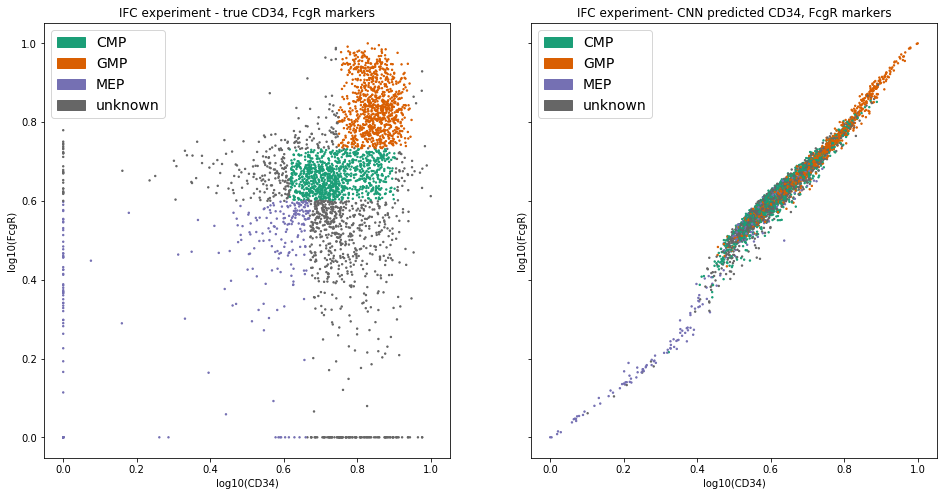

In [19]:
#plot the IFC-true and the new IFC-Brightfield-predicted markers side by side
fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(2*8,8))
ax=axes[0]
cell_colors_IFC=y_gate_IFC.cat.codes.values.copy()
cell_colors_IFC[cell_colors_IFC==3]=7#convert "unknown" cells to gray
ax.scatter(X_markers_img_01norm[:,0],X_markers_img_01norm[:,1],c=cmap(cell_colors_IFC),s=2)
ax.set_title('IFC experiment - true CD34, FcgR markers')
ax.set_xlabel('log10(CD34)')
ax.set_ylabel('log10(FcgR)')
ax.legend(handles=handles,prop={"size":14})
ax.legend(handles=handles,prop={"size":14})
ax=axes[1]
#Categories (3, object): [CD3+CD8+, CD3+CD8-, unknown]
cell_colors_IFC=y_gate_IFC.cat.codes.values.copy()
cell_colors_IFC[cell_colors_IFC==3]=7#convert "unknown" cells to gray
ax.scatter(X_markers_img_BF_01norm[:,0],X_markers_img_BF_01norm[:,1],c=cmap(cell_colors_IFC),s=2)
ax.set_title('IFC experiment- CNN predicted CD34, FcgR markers')
ax.set_xlabel('log10(CD34)')
ax.set_ylabel('log10(FcgR)')
ax.legend(handles=handles,prop={"size":14})
plt.show()

We can see that the MEP and GMP populations are easy to separate, even with Brightfield-predicted CD34 and FcgR markers. The middle population of CMP cells is correctly positioned between the MEP and GMP populations, but many CMP cells are hard to distingush from the "unknown" cells. We will proceed to plot the Label-free estimated gene expression on top of the ground truth, as well as the predicted markers.

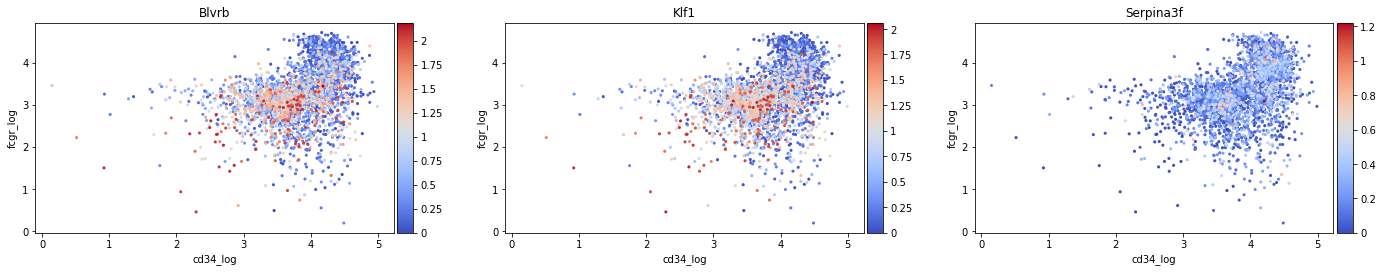

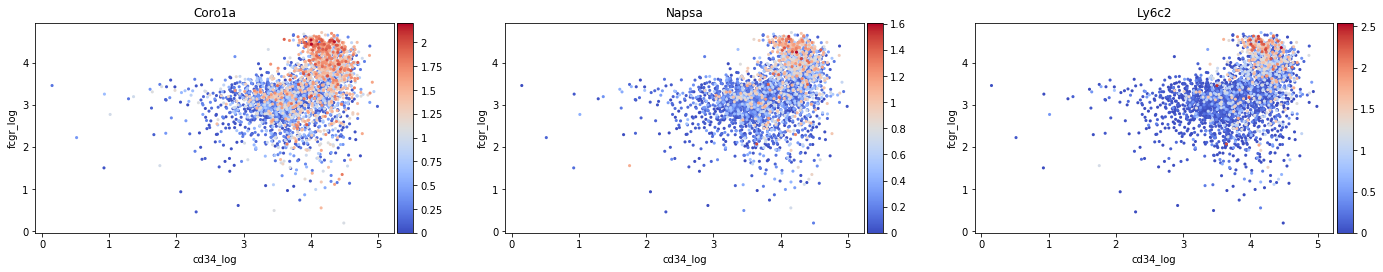

In [20]:
#Now let's plot the predicted expression for the same key markers as above
genes_to_plot = ['Blvrb',#MEP marker
                 'Klf1',#MEP marker
                 'Serpina3f']#CMP marker
sc.pl.scatter(adata_IFC_BF,'cd34_log','fcgr_log',color=genes_to_plot,color_map='coolwarm')
genes_to_plot = ['Coro1a',#CMP and GMP marker
                 'Napsa',#GMP marker
                 'Ly6c2']#GMP marker
sc.pl.scatter(adata_IFC_BF,'cd34_log','fcgr_log',color=genes_to_plot,color_map='coolwarm')

Label-free gene expression works well for the MEP and GMP markers. Blvrb and Klf1 are expressed in the region of the MEP population, Napsa and Ly6c2 are expressed in the GMP region and Coro1a: the common marker for CMP and GMP cells is expressed in both regions. However, the CMP marker Serpina3f is expresssed mostly in the CMP region, but predicted expression levels are low.

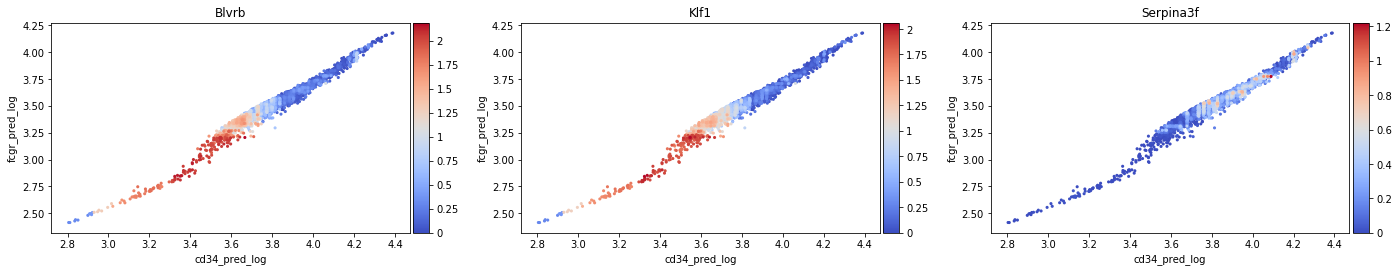

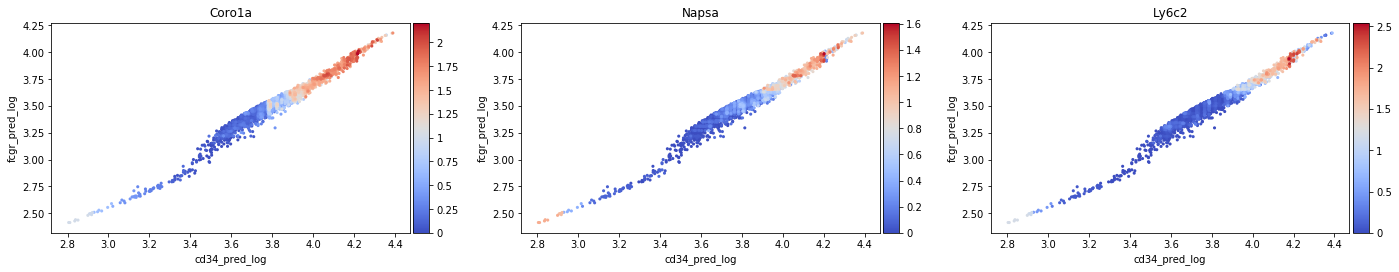

In [21]:
#Now let's plot the predicted expression for the same key markers as above
genes_to_plot = ['Blvrb',#MEP marker
                 'Klf1',#MEP marker
                 'Serpina3f']#CMP marker
sc.pl.scatter(adata_IFC_BF,'cd34_pred_log','fcgr_pred_log',color=genes_to_plot,color_map='coolwarm')
genes_to_plot = ['Coro1a',#CMP and GMP marker
                 'Napsa',#GMP marker
                 'Ly6c2']#GMP marker
sc.pl.scatter(adata_IFC_BF,'cd34_pred_log','fcgr_pred_log',color=genes_to_plot,color_map='coolwarm')

The overall impression is the same when estimated gene expression is predicted on top of the CNN predicted CD34 and FcgR markers. MEP markers are expressed in the MEP region, GMP markers are expressed in the GMP region. Coro1a is expressed in both the CMP and GMP populations, as expected. One difference to the above plot is that the CMP marker Serpina 3f is correct when plotted on top of the estimated CD34 and FcgR values. This means that the expression prediction model (Random Forest) is correct when predicting expression and the discrepancy between the two cases is due to the CNN-predicted markers being unable to adequately separate the CMP population from the bulk of "unknown" cells, as we saw in a previous plot.